In [1]:
from collections import namedtuple
from os import listdir

import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import numpy as np
import sys


%load_ext autoreload
%autoreload 2

sys.path.append('../PSO/pso/src/pso/')

# Atom structure

In [2]:
Atom = namedtuple('Atom', ['name', 'element', 'aminoacid', 'x', 'y', 'z', 'residue_seq_number'])

Atom.parse_name = lambda string: string[12:16].strip()
Atom.parse_element = lambda string: string[12] if len(string.strip()) < 78 \
                     else string[76:78].strip()
Atom.parse_aminoacid = lambda string: string[17:20].strip()
Atom.parse_x = lambda string: float(string[30:38].strip())
Atom.parse_y = lambda string: float(string[38:46].strip())
Atom.parse_z = lambda string: float(string[46:54].strip())
Atom.parse_residue_seq_number = lambda string: int(string[23:30].strip())

Atom.parse = lambda string: Atom(
    Atom.parse_name(string), Atom.parse_element(string), Atom.parse_aminoacid(string),
    Atom.parse_y(string), Atom.parse_x(string), Atom.parse_z(string), Atom.parse_residue_seq_number(string))

## Select the molecule to compare

In [3]:
path_molecules_to_compare = [f for f in listdir() 
                             if 'reference' not in f and f.endswith('.pdb')]
print(path_molecules_to_compare)

['1ACW-04.pdb', '1ACW-02.pdb', '1ACW-06.pdb', '1ACW-03.pdb', '1ACW-05.pdb', '1ACW-01.pdb']


## Read data from pdb file

In [4]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                try:
                    atoms.append(Atom.parse(line))
                except Exception as e:
                    print(e)
    return atoms

In [5]:
reference = pd.DataFrame(read_molecule('reference.pdb'))
molecules_to_compare = [pd.DataFrame(read_molecule(m)) \
                        for m in path_molecules_to_compare]

In [6]:
molecules_to_compare[0][:20]

,name,element,aminoacid,x,y,z,residue_seq_number
0,N,N,VAL,-2.044,-1.352,0.000,1
1,H1,H,VAL,-1.261,-1.990,0.000,1
2,H2,H,VAL,-2.540,-1.446,0.875,1
3,H3,H,VAL,-2.540,-1.446,-0.875,1
4,CA,C,VAL,-1.523,0.000,0.000,1
5,HA,H,VAL,-1.871,0.524,0.890,1
6,CB,C,VAL,-1.989,0.768,-1.232,1
7,HB,H,VAL,-3.078,0.814,-1.241,1
8,CG1,C,VAL,-1.500,0.056,-2.490,1
9,HG11,H,VAL,-0.411,0.010,-2.481,1


In [7]:
reference[:20]

,name,element,aminoacid,x,y,z,residue_seq_number
0,N,N,VAL,0.298,0.965,-0.467,1
1,CA,C,VAL,0.250,1.811,-1.701,1
2,C,C,VAL,0.400,3.290,-1.320,1
3,O,O,VAL,1.053,3.628,-0.346,1
4,CB,C,VAL,1.384,1.417,-2.664,1
5,CG1,C,VAL,1.262,-0.064,-3.035,1
6,CG2,C,VAL,2.744,1.666,-2.002,1
7,H1,H,VAL,1.180,1.151,0.051,1
8,H2,H,VAL,0.255,-0.040,-0.731,1
9,H3,H,VAL,-0.512,1.196,0.142,1


# RMSD calculation

* We can notice that the reference structure has a greater number of alpha carbons and amino acids residues.


* One approach to tackle this problem would be to `trim` the reference molecule so it will have the same amount of alpha carbons than the molecule to compare.


a) At first, we'll compute the RMSD using the beginning of the molecule reference. 



b) After, the same study will be made with the possibility of translations in the molecule to be compared. 

In [8]:
def apply_transformations(transformation, df):
    homogeneous_coordinates = df[['x', 'y', 'z']].copy()
    homogeneous_coordinates['_'] = 1.0
    return transformation.dot(homogeneous_coordinates.values.T).T[:, :-1]

In [9]:
def RMSD(molecule1, molecule2, functions=['CA'], 
         transformation1=np.eye(4), transformation2=np.eye(4)):
    
    molecule1 = molecule1[molecule1.name.isin(functions)].copy()
    molecule1 = apply_transformations(transformation1, molecule1)
    molecule2 = molecule2[molecule2.name.isin(functions)].copy()
    molecule2  = apply_transformations(transformation2, molecule2)
    
    smaller_size = min(len(molecule1), len(molecule2))
    squared_differences = (molecule1[:smaller_size] - \
                           molecule2[:smaller_size]) ** 2

    squared_distance = squared_differences.sum(axis=1)
    average_squared_distance = squared_distance.mean()
    average_distance = np.sqrt(average_squared_distance)
    return average_distance

## No Translation

Not applying any transfomation.
RMSD between the reference and molecule 1: 20.787576 Ångströns
RMSD between the reference and molecule 2: 35.708949 Ångströns
RMSD between the reference and molecule 3: 25.326716 Ångströns
RMSD between the reference and molecule 4: 23.615692 Ångströns
RMSD between the reference and molecule 5: 22.118981 Ångströns
RMSD between the reference and molecule 6: 23.519198 Ångströns


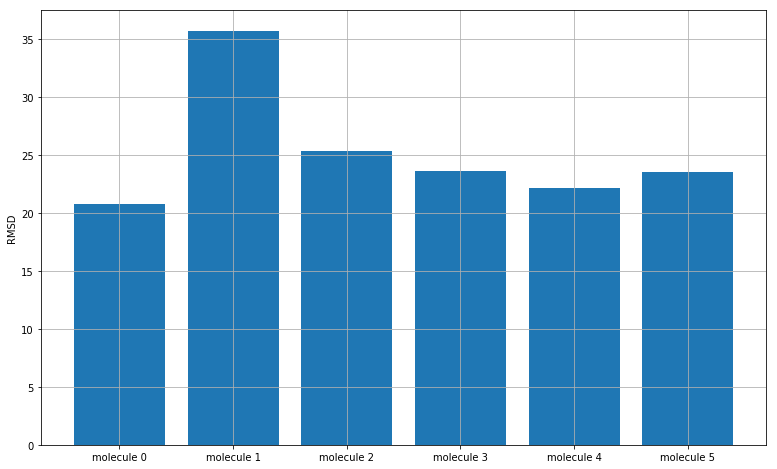

In [10]:
print('Not applying any transfomation.')
rmsd = []
labels = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    rmsd.append(RMSD(reference, molecules_to_compare[idx]))
    labels.append('molecule %d' % idx)
    print('RMSD between the reference and molecule %d: %f Ångströns' % \
          (idx + 1, rmsd[-1]))
    

plt.figure(figsize=(13, 8))
plt.ylabel('RMSD')
plt.bar(labels, rmsd)
plt.grid()
plt.show()

## With translation.

In [11]:
def infer_translation_matrix(molecule_to_be_displaced, ref_point):
    atom_to_displace =\
        molecule_to_be_displaced[molecule_to_be_displaced.name == 'CA'].iloc[0]
    
    T_MATRIX = np.eye(4)
    T_MATRIX[0, 3] = (ref_point.x - atom_to_displace.x)
    T_MATRIX[1, 3] = (ref_point.y - atom_to_displace.y)
    T_MATRIX[2, 3] = (ref_point.z - atom_to_displace.z)
    return T_MATRIX

* At first, we'll consider as a reference point the first carbon alpha of the molecule reference.

In [12]:
ref_point = reference[reference.name == 'CA'].iloc[0]

RMSD between the reference and molecule 1: 19.721576 Ångströns
RMSD between the reference and molecule 2: 33.803276 Ångströns
RMSD between the reference and molecule 3: 25.992975 Ångströns
RMSD between the reference and molecule 4: 24.416573 Ångströns
RMSD between the reference and molecule 5: 23.510216 Ångströns
RMSD between the reference and molecule 6: 23.214202 Ångströns


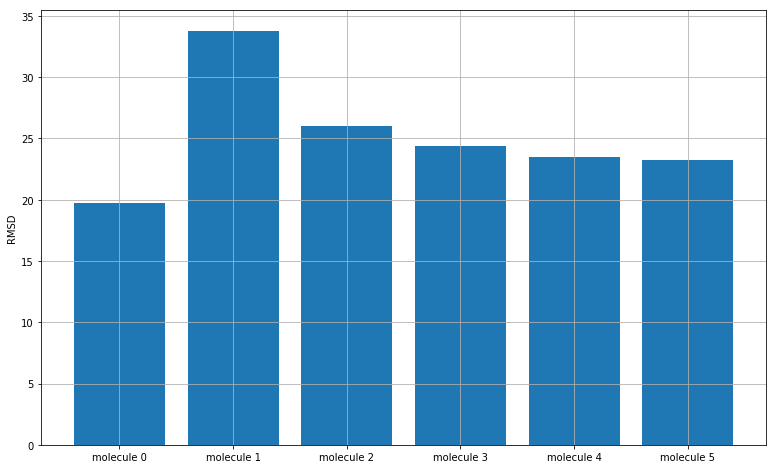

In [13]:
rmsd = []
labels = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    translation = infer_translation_matrix(molecule_to_compare, ref_point)
    rmsd.append(RMSD(reference, molecules_to_compare[idx], transformation2=translation))
    labels.append('molecule %d' % idx)
    print('RMSD between the reference and molecule %d: %f Ångströns' % \
          (idx + 1, rmsd[-1]))
    

plt.figure(figsize=(13, 8))
plt.ylabel('RMSD')
plt.bar(labels, rmsd)
plt.grid()
plt.show()

That's it!

***
---
***
---
***
---
***
***
---
***
---
***
---
***
***
---
***
---
***
---
***

# Calculating the best alignment.

* We will be using the library `pso` developed by assignee of this assignment.


* The PSO (Particle swarm optimization) is an heuristic method for finding global minima in cost/energy functions.


* For the molecule alignment problem, the **RMSD** is going to be the cost function that we want to minimize.


* The library requires an structure called `CostModel`, which defines the objective function, the boundaries and the number of parameters.

In [55]:
NUMBER_OF_PARTICLES = 10

In [56]:
from cost import CostModel
from pso import PSO
from plot import plot_states
from functools import partial

In [57]:
ref_point = reference[reference.name == 'CA'].iloc[0]
print('Reference point: ')
ref_point

Reference point: 


name                     CA
element                   C
aminoacid               VAL
x                      0.25
y                     1.811
z                    -1.701
residue_seq_number        1
Name: 1, dtype: object

In [58]:
boundary_min = reference[['x', 'y','z']].values.min() * 1.5
boundary_max = reference[['x', 'y','z']].values.max() * 1.5
print('Translation boundaries: ')
print('min: ', boundary_min, 'Ångströns')
print('max: ', boundary_max, 'Ångströns')

Translation boundaries: 
min:  -34.098 Ångströns
max:  26.814 Ångströns


In [59]:
def translation_matrix(delta_x, delta_y, delta_z, ref_x=.0, ref_y=.0, ref_z=.0):
    T = np.eye(4)
    T[0, -1], T[1, -1], T[2, -1] = delta_x - ref_x, delta_y - ref_y, delta_z - ref_z
    return T

## a) Optimize RMSD taking into account only the Backbone.

* Now, we are going to filter the atoms by removing hydrogens and the residues.


* Thus, only **Carbons, Nitrogens and Oxygens** are left.

* We are going to modify the previously defined RMSD function so we can compare the exact same atoms of each structure. 


* Still using only the beginning of the reference molecule. 

In [63]:
reference_cropped = reference[:410].copy()

In [64]:
def RMSD(molecule1, molecule2, elements=['C', 'N', 'O'],
         transformation1=np.eye(4), transformation2=np.eye(4), how='merge'):
    molecule1 = molecule1[molecule1.element.isin(elements)].copy()
    molecule1[['x', 'y','z']] = apply_transformations(transformation1, molecule1)
    
    molecule2 = molecule2[molecule2.element.isin(elements)].copy()
    molecule2[['x', 'y','z']] = apply_transformations(transformation2, molecule2)


    if how == 'groupby':
        molecule1['type'] = 'reference'
        molecule2['type'] = 'to_compare'
        both_molecules = molecule1.append(molecule2).reset_index(drop=True)

        def compute_squared_differences(group):
            to_compare = group[group.type == 'to_compare'].iloc[0]
            ref = group[group.type == 'reference'].iloc[0]
            group = pd.concat([to_compare, ref], axis=1).T
            coordinates = group.loc[:, ['x', 'y', 'z']]
            squared_differences = (coordinates.iloc[1] - coordinates.iloc[0]) ** 2
            return squared_differences.sum()

        rmsd = np.sqrt(
            both_molecules.groupby(['name', 'residue_seq_number']).apply(compute_squared_differences).mean())

    elif how == 'merge':
        molecules_df = pd.merge(molecule1, molecule2, on=['residue_seq_number', 'name'])
        molecules_df['x_distance_squared'] = (molecules_df['x_x'] - molecules_df['x_y']) ** 2
        molecules_df['y_distance_squared'] = (molecules_df['y_x'] - molecules_df['y_y']) ** 2
        molecules_df['z_distance_squared'] = (molecules_df['z_x'] - molecules_df['z_y']) ** 2

        molecules_df['euclidean_distance_squared'] = \
            (molecules_df['x_distance_squared'] + molecules_df['y_distance_squared'] + molecules_df['z_distance_squared'])

        rmsd = np.sqrt(np.mean(molecules_df['euclidean_distance_squared']))
    return rmsd

In [ ]:
backbone_states = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    cost_model = CostModel(
        callable=lambda T:\
            RMSD(reference_cropped, molecule_to_compare,
                 transformation1=np.eye(4),
                 transformation2=translation_matrix(T[0], T[1], T[2], ref_x=ref_point.x, ref_y=ref_point.y, ref_z=ref_point.z)),
        num_dimensions=3,
        parameters_boundaries=[boundary_min, boundary_max],
        name='RMSD between reference and molecule %d.' % idx
    )

    pso = PSO(cost_model, num_particles=NUMBER_OF_PARTICLES, max_iter=300, min_cummulative_error=1E-2)
    backbone_states.append(pso.optimize())

### RMSD of all the average position of all particles.

In [ ]:
for backbone_state in backbone_states:
    average_positions = np.array([np.mean(np.vstack(list(particles_position.values())), axis=0) for particles_position in backbone_state['particles_positions']])
    
    rmsd = [cost_model.callable(average_position) for average_position in average_positions]
    
    plt.figure(figsize=(13, 8))
    plt.ylabel('RMSD error')
    plt.plot(rmsd)
    plt.grid()
    plt.show()
    print('Final average RMSD:', rmsd[-1])
    print('Final average translation:', average_positions[-1, :], 'Ångströns')

## b) Optimize RMSD taking into account only the alpha carbons.

In [ ]:
backbone_states = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    cost_model = CostModel(
        callable=lambda T:\
            RMSD(reference_cropped[reference_cropped.name == 'CA'], molecule_to_compare[molecule_to_compare.name == 'CA'],
                 transformation1=np.eye(4),
                 transformation2=translation_matrix(T[0], T[1], T[2], ref_x=ref_point.x, ref_y=ref_point.y, ref_z=ref_point.z)),
        num_dimensions=3,
        parameters_boundaries=[boundary_min, boundary_max],
        name='RMSD between reference and molecule %d.' % idx
    )

    pso = PSO(cost_model, num_particles=NUMBER_OF_PARTICLES, max_iter=300, min_cummulative_error=1E-2)
    backbone_states.append(pso.optimize())

### RMSD of all the average position of all particles.

In [ ]:
for backbone_state in backbone_states:
    average_positions = np.array([np.mean(np.vstack(list(particles_position.values())), axis=0) for particles_position in backbone_state['particles_positions']])
    
    rmsd = [cost_model.callable(average_position) for average_position in average_positions]
    
    plt.figure(figsize=(13, 8))
    plt.ylabel('RMSD error')
    plt.plot(rmsd)
    plt.grid()
    plt.show()
    print('Final average RMSD:', rmsd[-1])
    print('Final average translation:', average_positions[-1, :], 'Ångströns')

## b) Optimize RMSD taking into account all the atoms.

In [ ]:
backbone_states = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    cost_model = CostModel(
        callable=lambda T:\
            RMSD(reference_cropped, molecule_to_compare, elements=['C', 'N', 'O', 'H']
                 transformation1=np.eye(4),
                 transformation2=translation_matrix(T[0], T[1], T[2], ref_x=ref_point.x, ref_y=ref_point.y, ref_z=ref_point.z)),
        num_dimensions=3,
        parameters_boundaries=[boundary_min, boundary_max],
        name='RMSD between reference and molecule %d.' % idx
    )

    pso = PSO(cost_model, num_particles=NUMBER_OF_PARTICLES, max_iter=300, min_cummulative_error=1E-2)
    backbone_states.append(pso.optimize())

### RMSD of all the average position of all particles.

In [ ]:
for backbone_state in backbone_states:
    average_positions = np.array([np.mean(np.vstack(list(particles_position.values())), axis=0) for particles_position in backbone_state['particles_positions']])
    
    rmsd = [cost_model.callable(average_position) for average_position in average_positions]
    
    plt.figure(figsize=(13, 8))
    plt.ylabel('RMSD error')
    plt.plot(rmsd)
    plt.grid()
    plt.show()
    print('Final average RMSD:', rmsd[-1])
    print('Final average translation:', average_positions[-1, :], 'Ångströns')

That's all!